<h3>Exercise Sheet 01</h3>
<h2>Locally Linear Embedding (40P)</h2>

In this assignment we will look at locally linear embedding and experiment with it on artificially generated datasets. The effects of neighbourhood size and noise on result quality will be analyzed.

Information about the algorithm, publications and demos can be found at http://www.cs.nyu.edu/~roweis/lle/

A guide for plotting can be found here: http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-4-Matplotlib.ipynb

It might be necessary to update anaconda and scipy for this exercise. On Linux this can be done using

* conda update conda
* conda update scipy

Submission guidelines: To facilitate grading, please export the notebook to PDF format. This can be done easily by
installing the required packages and running
ipython nbconvert –to latex sheet01_code.ipynb && pdﬂatex sheet01_code.tex

Upload your .ipynb and .pdf together on ISIS. Include the name of your group. 

<h4>Declare everything you'll be using here</h4>

In [1]:
import numpy as np
from pylab import *
from mpl_toolkits.mplot3d.axes3d import Axes3D
%pylab inline
import scipy.spatial, scipy.linalg

Populating the interactive namespace from numpy and matplotlib


`%pylab --no-import-all` prevents importing * from pylab and numpy


Data for this assignment will be generated using utils.get_data(type, n, sigma). Every point has an associated color which reflects the proximity of the points.

* There are 4 data types 1-4 
* n determines the number of samples which will be generated
* $\sigma$ determines the amount of noise added to the data

This is what the the data looks like:

Populating the interactive namespace from numpy and matplotlib


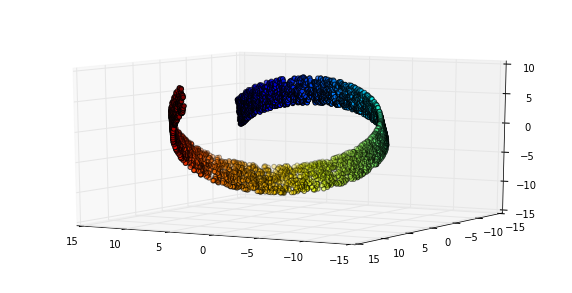

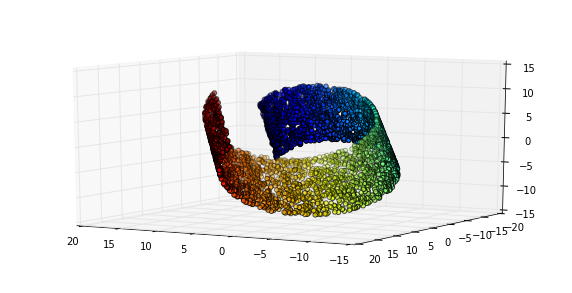

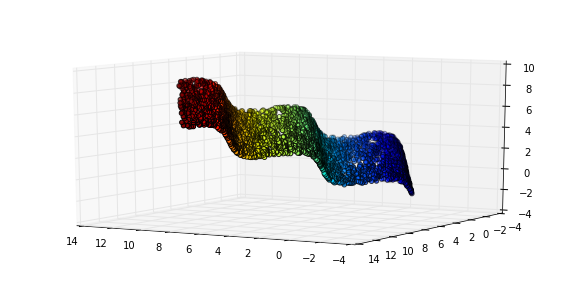

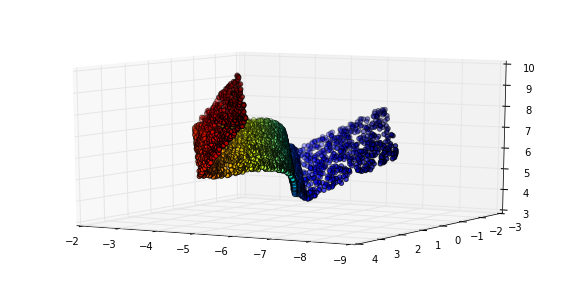

In [1]:
import utils
%pylab inline
utils.plot_demo(angle=120)

<h3>Part I: Implementing LLE (20P)</h3>

Implement LLE and determine the resulting 2D embedding of the data for the given neighbourhood size.

Reminder: During computation, you need to solve the problem Cw=**1**, where **1** is a column vector (1,1,...,1). In case k>d i.e. the size of the neighbourhood is larger than the number of dimensions of the space we're mapping to, it is necessary to regularize the matrix C. You can do this by perturbing the diagonals. Make sure you do not regularize too much (i.e. perturbation too large compared to the values of C). 

Numpy's package for linear algebra (numpy.linalg) should have everything you need. 

The data shape is Nxd, where N is the number of samples and d the number of dimensions.

Populating the interactive namespace from numpy and matplotlib


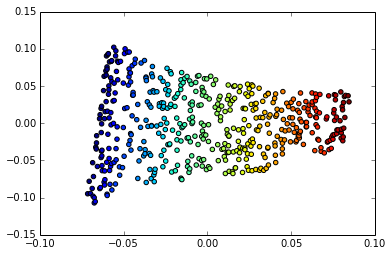

In [2]:
import solutions
import utils
%pylab inline
print "Sample"
data,color = utils.get_data(type=2,n=500,sigma=0)
embedding = solutions.LLE(data, k = 10) 
plt.scatter(embedding[:,0],embedding[:,1],c=color) #Include this plot in your submission (as a small test).

In [80]:
def knn_search(x, data, K):
    D= data.shape[0] # number of data
    K = K if K < D else D # K-nearest neighbors may not be more than data points given
    
    # euclidean distance
    dist = np.sqrt(((data - x)**2).sum(axis=1))
    idx = np.argsort(dist) # sorting
    # return the indices of K nearest neighbors
    return idx[:K]

In [215]:
def lle(data, K, d):
    N, D = data.shape
    tol = 1e-3 if K > D else 0 # regularization if K > D
    
    W = np.zeros((N,K))
    for i in range(N):
        # find neighborhood for each datapoint
        # idx of k Nearest neighbors
        nbh_idx = knn_search(data[i,:],data, K+1)[1:] # K+1 as one finding will be Xi itself

        # solve reconstruction for weights W

        Z = data[nbh_idx,:] # kNN samples
        Z = Z - data[i,:] # substract Xi from every neighbor
        C = np.dot(Z,Z.T) # local covariance - K x K 
        C = C + eye(K,K) * tol * trace(C) # regularization
        
        w = np.linalg.solve(C,1) # solve Cw=1
        w = (w/float(sum(w))).T
        W[i,:] = w # set Wij = w/sum(w) for every neighbor
        
    M = eye(N,N)
    for i in range(N):
        # create sparse matrix M
        M[nbh_idx,i] = M[nbh_idx,i] - w
        M[i,nbh_idx] = M[i,nbh_idx] - w
        M[nbh_idx,nbh_idx] = M[nbh_idx,nbh_idx] + np.dot(w.T,w)
        
    # compute embedding
    eig_vals, eig_vecs = np.linalg.eig(M)
    i = np.argsort(eig_vals)[::-1] # sort by magnitude
    eig_vecs = eig_vecs[:, i]
    eig_vecs = eig_vecs[:,1:d+1] # omit first eig_vec and select only d largest
    Y = eig_vecs *  np.sqrt(N)
    return Y


In [229]:
def lle2(data, K, d):
    N, D = data.shape
    tol = 1e-3 if K > D else 0 # regularization if K > D
    nbh = np.zeros((N,K))
    W = np.zeros((N,K))
    for i in range(N):
        # find neighborhood for each datapoint
        # idx of k Nearest neighbors
        nbh_idx = knn_search(data[i,:],data, K+1)[1:] # K+1 as one finding will be Xi itself
        nbh[i,:] = nbh_idx
        # solve reconstruction for weights W

        Z = data[nbh_idx,:] # kNN samples
        Z = Z - data[i,:] # substract Xi from every neighbor
        C = np.dot(Z,Z.T) # local covariance - K x K 
        C = C + eye(K,K) * tol * trace(C) # regularization
        
        w = np.linalg.solve(C,1) # solve Cw=1
        w = (w/float(sum(w))).T
        W[i,:] = w # set Wij = w/sum(w)

    
    M = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            identity = np.ones((1,K)) if i==j else np.zeros((1,K)) # mimic identity matrix
            # current element form (I - W)
            w = W[i,:] if j in nbh[i,:] else np.zeros((1,K)) # w zero for every non-neighbor of i
            
            # current element form (I - W).T
            wt = W[j,:] if i in nbh[j,:] else np.zeros((1,K)) 
            M[i,j] = sum((identity - w) * (identity - wt))
    
    # compute embedding
    eig_vals, eig_vecs = np.linalg.eig(M)
    i = np.argsort(eig_vals)[::-1] # sort by magnitude
    eig_vecs = eig_vecs[:, i]
    eig_vecs = eig_vecs[:,1:d+1] # omit first eig_vec and select only d largest
    Y = eig_vecs *  np.sqrt(N)
    return Y

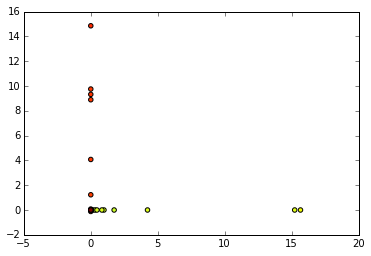

In [230]:
Y = lle2(data,5,2)
plt.scatter(Y[:,0],Y[:,1],c=color) 

True

In [185]:
test = np.ones((3,3))
test[0,:] = range(0,3)
test[1,:] = range(3,6)
test[2,:] = range(6,9)

a = [1,2]
b = np.ones((1,3))
c = np.ones((3,1))
print test[a,:]
print test[a,:] - c.T

[[ 3.  4.  5.]
 [ 6.  7.  8.]]
[[ 2.  3.  4.]
 [ 5.  6.  7.]]


In [33]:
Z = np.ones((K,data.shape[1]))
for i in range(data.shape[0]):
    Z = data[nbh[i,:],:]

[[   7.   19.    1. ...,   25.   30.   27.]
 [  15.   14.    2. ...,   34.   38.   42.]
 [  20.   22.    0. ...,   26.   19.   28.]
 ..., 
 [ 492.  490.  482. ...,  491.  469.  474.]
 [ 493.  494.  488. ...,  495.  481.  476.]
 [ 496.  478.  477. ...,  468.  467.  463.]]


500
500
500


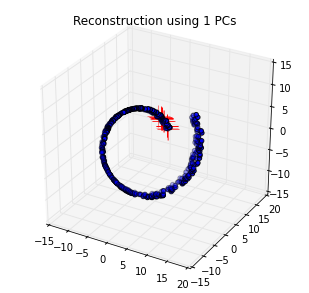

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# plot reconstructions
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(data[:,0].tolist(), data[:,1].tolist(), data[:,2].tolist())
ax.set_title('Reconstruction using 1 PCs')

ax.scatter(data[knn_search([1,1,1],data,12),0].tolist(),
           data[knn_search([1,1,1],data,12),1].tolist(),
           data[knn_search([1,1,1],data,12),2].tolist(),
          marker='+', s=500, c='r')

plt.show()

<h3>Part 2: Experiments (20P)</h3>

Using your implementation and the provided helper function for plotting, examine with various combinations of n, $\sigma$ and K. Find an embedding you think is good and one that you think is bad (i.e. doesn't show the manifold). Examine how robust LLE is ( i.e. how noise impacts the quality of the given embedding). 

In addition, briefly answer the following questions:

* When applying LLE to a 200-dimensional dataset which can't be visualized, how would you assess whether the found embedding is good? Discuss how you would do it or argue why it can't be done.
* Could utilizing this technique in conjuction with a classifier improve its performance? Which classifiers, if any, would benefit the most?

A helper function is provided below. Values of sigma and K to be examined can be set using LLE_plot_helper(SIGMA = [0,1,2].K = [1,2,3] ) 

SAMPLE


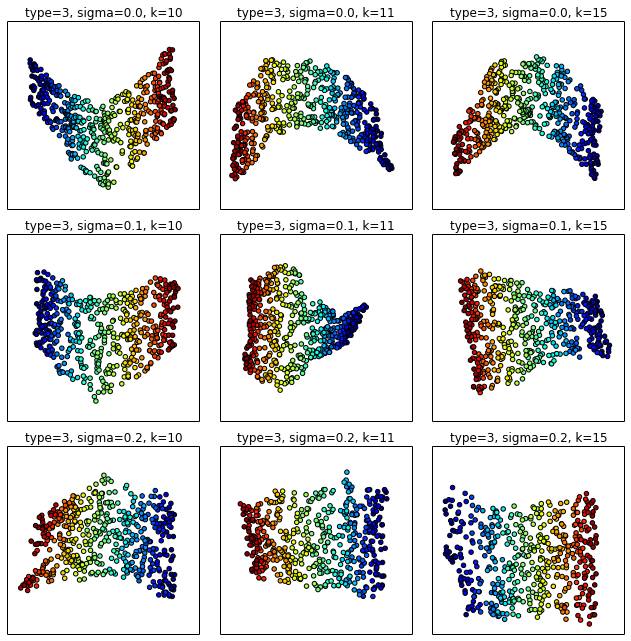

In [17]:
import utils
import solutions
def LLE_plot_helper(type=1, n=500, SIGMA=np.arange(0.0, 0.3,0.1), K=[10,11,15]):
    cols = len(K)
    rows = len(SIGMA)
    print "SAMPLE" #Replace with the name of your group
    fig = plt.figure(figsize=(3*cols, 3*rows))
    for i, k in enumerate(K):
        for j, sigma in enumerate(SIGMA):
            ax = fig.add_subplot(rows, cols, 1+j*cols+i)
            data, color = utils.get_data(type=type, n=n, sigma=sigma)
            y = solutions.LLE(data, k=k) #Replace with your own implementation
            ax.scatter(y[:,0], y[:,1], c=color)
            plt.title('type={}, sigma={}, k={}'.format(type, sigma, k))
            plt.xticks([], [])
            plt.yticks([], [])
    plt.tight_layout()
    plt.show()
LLE_plot_helper(type=3)
